<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Neural Networks Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>

</div>

## Loading Dataset

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/ssarkar445/covid-19-xray-and-ct-scan-image-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: orhanhasanpour
Your Kaggle Key: ··········


100%|██████████| 3.74G/3.74G [00:23<00:00, 168MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121
import tensorflow as tf

In [ ]:
disease_types=['COVID', 'Non-COVID']
data_dir = '/content/covid-19-xray-and-ct-scan-image-dataset/COVID-19 Dataset/CT'
train_dir = os.path.join(data_dir)

In [ ]:

data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        data.append(['{}/{}'.format(sp, file), defects_id, sp])

dataset = pd.DataFrame(data, columns=['File', 'DiseaseID','Disease Type'])
dataset.head()



,File,DiseaseID,Disease Type
0,COVID/coronacases_org_003_z179.png,0,COVID
1,COVID/coronacases_org_010_z043.png,0,COVID
2,COVID/radiopaedia_org_covid-19-pneumonia-10_85...,0,COVID
3,COVID/coronacases_org_010_z178.png,0,COVID
4,COVID/coronacases_org_008_z045.png,0,COVID


In [ ]:

dataset = dataset.sample(frac=1, random_state=42)
dataset.index = np.arange(len(dataset)) # Reset indices
dataset.head()

,File,DiseaseID,Disease Type
0,COVID/tr_im_z094.png,0,COVID
1,Non-COVID/1.3.6.1.4.1.14519.5.2.1.6279.6001.22...,1,Non-COVID
2,COVID/tr_mask_z079.png,0,COVID
3,Non-COVID/1.3.6.1.4.1.14519.5.2.1.6279.6001.12...,1,Non-COVID
4,COVID/tr_mask_z069.png,0,COVID


(630, 630, 3)

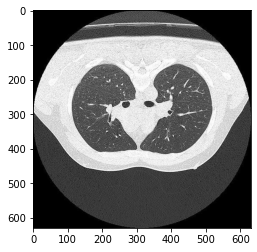

In [ ]:
image_path = os.path.join(data_dir, dataset['File'][50])
img=cv2.imread(image_path)
plt.imshow(img)
img.shape

## Read and Resize

In [ ]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:

img_size = 64
X = np.zeros((dataset.shape[0], img_size, img_size, 3))
for i, file in tqdm(enumerate(dataset['File'].values)):
    image = read_image(file)
    if image is not None:
        X[i] = resize_image(image, (img_size, img_size))
# Normalize the data
X = X / 255.
print('Train Shape: {}'.format(X.shape))



8055it [00:40, 199.96it/s]


Train Shape: (8055, 64, 64, 3)


In [ ]:
Y = dataset['DiseaseID'].values
Y = to_categorical(Y, num_classes=2)

In [ ]:
# Split the train and validation and test sets
X_train1, X_test, Y_train1, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train1, Y_train1, test_size=0.2, random_state=42)

## Data Augmentation

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(5155, 64, 64, 3)
(1289, 64, 64, 3)
(1611, 64, 64, 3)
(5155, 2)
(1289, 2)
(1611, 2)


## Model Architecture

In [ ]:
densenet = DenseNet121(weights='imagenet', include_top=False)
input = tf.keras.Input(shape=(64, 64, 3))
x = Conv2D(3, (3, 3), padding='same')(input)

x = densenet(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# multi output
output = Dense(2,activation = 'softmax', name='root')(x)
model = Model(input,output)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_4 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0   

## Train

In [ ]:
batch = 64
n_epoch=50
Optim = tf.keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=Optim, metrics=['accuracy'])
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch),
               steps_per_epoch=X_train.shape[0] // batch,
               epochs=n_epoch,
               validation_data=(X_val,Y_val))

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-56-590c62d91729>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch),


Epoch 1/50
80/80 [==============================] - 28s 180ms/step - loss: 1.0440 - accuracy: 0.6007 - val_loss: 0.7168 - val_accuracy: 0.6874
Epoch 2/50
80/80 [==============================] - 10s 130ms/step - loss: 0.6861 - accuracy: 0.7181 - val_loss: 0.6024 - val_accuracy: 0.7075
Epoch 3/50
80/80 [==============================] - 10s 121ms/step - loss: 0.4914 - accuracy: 0.7812 - val_loss: 0.5703 - val_accuracy: 0.7292
Epoch 4/50
80/80 [==============================] - 10s 122ms/step - loss: 0.4068 - accuracy: 0.8148 - val_loss: 0.5700 - val_accuracy: 0.7471
Epoch 5/50
80/80 [==============================] - 13s 159ms/step - loss: 0.3621 - accuracy: 0.8330 - val_loss: 0.2987 - val_accuracy: 0.8619
Epoch 6/50
80/80 [==============================] - 10s 120ms/step - loss: 0.3395 - accuracy: 0.8399 - val_loss: 0.2750 - val_accuracy: 0.8813
Epoch 7/50
80/80 [==============================] - 10s 121ms/step - loss: 0.3325 - accuracy: 0.8525 - val_loss: 0.2481 - val_accuracy: 0.8945

# Loss and Accuracy Curves

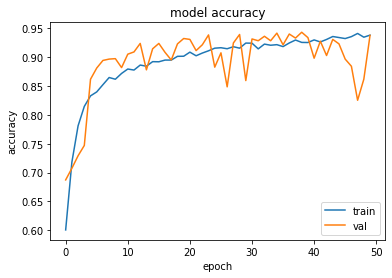

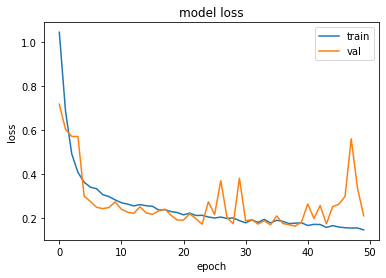

In [ ]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Results on Test Set

51/51 [==============================] - 1s 20ms/step - loss: 0.1559 - accuracy: 0.9323
Loss(Error): 0.15593251585960388, Accuracy: 0.932340145111084
51/51 [==============================] - 1s 16ms/step
Confusion Matrix: 
[[1019   42]
 [  67  483]]
accuracy:  0.9323401613904407
precision:  [0.93830571 0.92      ]
f1_score:  [0.94923149 0.89860465]
precision (Macro Average):  0.9291528545119705
f1_score (Macro Average):  0.923918068478461


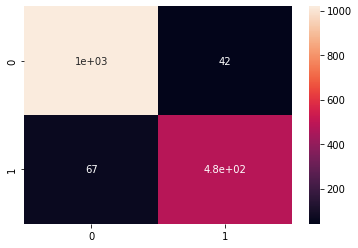

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
#Loss and Accuracy
Loss, Accuracy = model.evaluate(X_test, Y_test)
print('Loss(Error): {}, Accuracy: {}'.format(Loss, Accuracy))

# predict crisp classes for test set
yhat = model.predict(X_test)
y_pred = np.argmax(yhat,axis=1)
Y_test_binary= np.argmax(Y_test,axis=1)
#confusion matrix
cf_matrix = confusion_matrix(Y_test_binary, y_pred)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)
print('Confusion Matrix: ')
print(cf_matrix)
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test_binary, y_pred)
print('accuracy:  %s' % accuracy)
# precision: tp / (tp + fp)
precision = precision_score(Y_test_binary, y_pred,average=None)
print('precision:  %s' % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test_binary, y_pred,average=None)
print('f1_score:  %s' % f1)

## macro
# precision: tp / (tp + fp)
precision = precision_score(Y_test_binary, y_pred,average='macro')
print('precision (Macro Average):  %s' % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test_binary, y_pred,average='macro')
print('f1_score (Macro Average):  %s' % f1)